In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

pd.options.display.max_columns = 200

In [2]:
basedir = Path().resolve().parent
datadir = basedir / "data"
cachedir = basedir / "cache"
logdir = basedir / "logs"

In [5]:
valid_preds = pd.read_csv(logdir / "lstm-less-addfeatures-cut-large-custom-mae" / "valid_preds.csv", index_col=0)
train = pd.read_csv(cachedir / "train_lstm-less-cut-addfeatures_debugFalse.csv")
train.head()

,time_step,u_in,u_out,pressure,kfold,count,corss,cross2,cross3,time_delta,time_step_cumsum,u_in_cumsum,u_in_cummean,u_in_lag_b1,u_out_lag_b1,u_in_lag_b2,u_out_lag_b2,u_in_lag_b3,u_out_lag_b3,u_in_lag_b4,u_out_lag_b4,u_in_lag_b5,u_out_lag_b5,u_in_lag_f1,u_out_lag_f1,u_in_lag_f2,u_out_lag_f2,u_in_lag_f3,u_out_lag_f3,u_in_lag_f4,u_out_lag_f4,u_in_lag_f5,u_out_lag_f5,u_in_diff_b1,u_out_diff_b1,u_in_diff_b2,u_out_diff_b2,u_in_diff_b3,u_out_diff_b3,u_in_diff_b4,u_out_diff_b4,u_in_diff_b5,u_out_diff_b5,u_in_diff_f1,u_out_diff_f1,u_in_diff_f2,u_out_diff_f2,u_in_diff_f3,u_out_diff_f3,u_in_diff_f4,u_out_diff_f4,u_in_diff_f5,u_out_diff_f5,u_in_bwindow_mean,u_in_bwindow_max,u_in_bwindow_min,u_in_bwindow_std,u_in_fwindow_mean,u_in_fwindow_max,u_in_fwindow_min,u_in_fwindow_std,u_in_cwindow_mean,u_in_cwindow_max,u_in_cwindow_min,u_in_cwindow_std,u_in_bwindow_ewm,u_in_fwindow_ewm,u_in_cwindow_ewm,u_in_bwindow_mean_diff,u_in_bwindow_max_diff,u_in_bwindow_min_diff,u_in_fwindow_mean_diff,u_in_fwindow_max_diff,u_in_fwindow_min_diff,u_in_cwindow_mean_diff,u_in_cwindow_max_diff,u_in_cwindow_min_diff,area,area_insp,area_insp_last,u_in_max,u_in_mean,u_in_std,area_max,area_insp_max,area_mean,area_insp_mean,vibs,RC_20_10,RC_20_20,RC_20_50,RC_50_10,RC_50_20,RC_50_50,RC_5_10,RC_5_20,RC_5_50,R_20,R_5,R_50,C_10,C_20,C_50,norm_time_step,u_in_max_diff,area_max_diff,area_insp_max_diff,u_in_mean_diff,area_mean_diff,area_insp_mean_diff
0,0.00000,0.0833,0,5.836,4,1,0.0,0.00000,0.0,0.00000,0.00000,0.0833,0.0833,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,18.39,0.0,22.52,0.0,22.81,0.0,25.36,0.0,27.27,0.0,0.0000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-18.3000,0.0,-22.420,0.0,-22.720,0.0,-25.270,0.0,-27.170,0.0,0.013885,0.0833,0.0,0.03105,19.40,27.27,0.0833,9.0600,5.120,22.52,0.0,8.91,0.05957,26.45,20.69,0.06946,0.0,0.0833,-19.310,-27.170,0.0,-5.040,-22.420,0.0833,0.0000,0.0000,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.00000,-28.230,-22.60,-22.60,-18.8800,-13.580,-13.580
1,0.03366,18.3900,0,5.906,4,2,0.0,0.03366,0.0,0.03366,0.03366,18.4700,9.2340,0.0833,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,22.52,0.0,22.81,0.0,25.36,0.0,27.27,0.0,27.12,0.0,18.3000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-4.1250,0.0,-4.426,0.0,-6.973,0.0,-8.875,0.0,-8.740,0.0,3.078000,18.3900,0.0,6.84400,23.90,27.27,18.3900,3.0920,7.973,22.81,0.0,10.34,13.16000,26.94,22.34,15.30500,0.0,18.3900,-5.523,-8.875,0.0,10.410,-4.426,18.3900,0.6187,0.6187,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.02907,-9.930,-21.97,-21.97,-0.5767,-12.960,-12.960
2,0.06750,22.5200,0,7.875,4,3,0.0,0.06750,0.0,0.03387,0.10120,40.9700,13.6600,18.3900,0.0,0.0833,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,22.81,0.0,25.36,0.0,27.27,0.0,27.12,0.0,26.81,0.0,4.1250,0.0,22.420,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-0.2996,0.0,-2.846,0.0,-4.750,0.0,-4.617,0.0,-4.297,0.0,6.830000,22.5200,0.0,9.70000,25.31,27.27,22.5200,1.9770,11.140,25.36,0.0,11.26,19.84000,26.84,24.69,15.68000,0.0,22.5200,-2.803,-4.750,0.0,11.370,-2.846,22.5200,1.3810,1.3810,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.05832,-5.805,-21.22,-21.22,3.5490,-12.195,-12.195
3,0.10156,22.8100,0,11.740,4,4,0.0,0.10156,0.0,0.03403,0.20280,63.7800,15.9450,22.5200,0.0,18.3900,0.0,0.0833,0.0,0.0000,0.0,0.0,0.0,25.36,0.0,27.27,0.0,27.12,0.0,26.81,0.0,27.86,0.0,0.2996,0.0,4.426,0.0,22.720,0.0,0.00,0.0,0.0,0.0,-2.5470,0.0,-4.450,0.0,-4.320,0.0,-3.998,0.0,-5.055,0.0,10.630000,22.8100,0.0,10.69500,26.20,27.86,22.8100,1.7000,14.550,27.27,0.0,11.49,21.97000,27.58,26.69,12.18000,0.0,22.8100,-3.395,-5.055,0.0,8.260,-4.450,22.8100,2.1560,2.1560,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.08770,-5.504,-20.44,-20.44,3.8500,-11.420,-11.420
4,0.13570,25.3600,0,12.234,4,5,0.0,0.13570,0.0,0.03420,0.33840,89.1000,17.8300,22.8100,0.0,22.5200,0.0,18.3900,0.0,0.0833,0.0,0.0,0.0,27.27,0.0,27.12,0.0,26.81,0.0,27.86,0.0,28.31,0.0,2.5470,0.0,2.846,0.0,6.973,0.0,2

In [6]:
train_df = train.copy()[["u_in", "u_out", "pressure", "kfold"]]
train_df["pred"] = valid_preds.values.reshape(-1)
train_df.head()

,u_in,u_out,pressure,kfold,pred
0,0.0833,0,5.836,4,5.797
1,18.3900,0,5.906,4,5.880
2,22.5200,0,7.875,4,7.906
3,22.8100,0,11.740,4,11.870
4,25.3600,0,12.234,4,12.370


In [7]:
def compute_metric(df, merge=True):
    y_true, y_pred, u_out = df["pressure"].values, df["pred"].values, df["u_out"].values
    w = (1 - u_out)
    
    if merge:
        mae = w * np.abs(y_true - y_pred)
        mae = np.sum(mae) / np.sum(w)
        return mae
    else:
        y_true, y_pred, w = y_true.reshape(-1, 35), y_pred.reshape(-1, 35), w.reshape(-1, 35)
        maes = []
        for yt, yp, w_ in zip(y_true, y_pred, w):
            mae = w_ * np.abs(yt - yp)
            mae = np.sum(mae) / np.sum(w_)
            maes.append(mae)
        return np.array(maes)

In [47]:
def plot_i(df, i):
    df_ = df.iloc[35 * i : 35 * (i + 1), :]
    y_true, y_pred, u_out = df_["pressure"].values, df_["pred"].values, df_["u_out"].values
    
    mae = (1 - u_out) * np.abs(y_true - y_pred)
    mae = np.sum(mae) / np.sum(1 - u_out)
    
    fig, ax = plt.subplots(1, 1, figsize=(6 ,4))
    ax.plot(y_true, label="pressure")
    ax.plot(y_pred, label="prediction")
    ax.plot(u_out, label="u_out")
    ax.set_title(np.round(mae, 5))
    
    ax.legend()

In [20]:
scores = compute_metric(train_df, False)

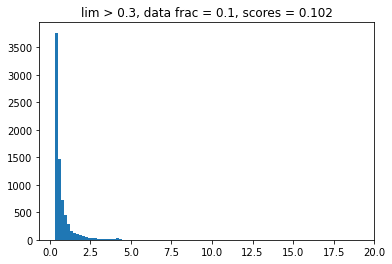

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
lim = 0.3
ax.hist(scores[scores > lim], bins=100)
ax.set_title(f"lim > {lim}, data frac = {np.round((scores > lim).sum() / len(scores), 3)}, scores = {np.round(scores[scores < lim].mean(), 3)}")
plt.show()

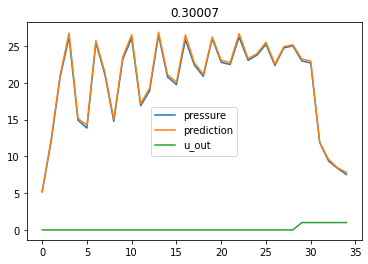

In [101]:
outer_scores = scores[scores > lim]
outer_idxs = np.arange(len(scores))[scores > lim]

_idxs = np.argsort(outer_scores)
outer_idxs = outer_idxs[_idxs]
outer_scores = outer_scores[_idxs]

plot_i(train_df, outer_idxs[0])

In [108]:
np.tile(np.arange(10), (35, 1)).T.reshape(-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [112]:
reliables = np.tile(scores < lim, (35, 1)).T.reshape(-1)
reliables, reliables.shape, reliables.sum() / reliables.shape[0]

(array([ True,  True,  True, ...,  True,  True,  True]),
 (2640750,),
 0.8997349237905898)

In [113]:
train["is_reliable"] = reliables
train.head()

,time_step,u_in,u_out,pressure,kfold,count,corss,cross2,cross3,time_delta,time_step_cumsum,u_in_cumsum,u_in_cummean,u_in_lag_b1,u_out_lag_b1,u_in_lag_b2,u_out_lag_b2,u_in_lag_b3,u_out_lag_b3,u_in_lag_b4,u_out_lag_b4,u_in_lag_b5,u_out_lag_b5,u_in_lag_f1,u_out_lag_f1,u_in_lag_f2,u_out_lag_f2,u_in_lag_f3,u_out_lag_f3,u_in_lag_f4,u_out_lag_f4,u_in_lag_f5,u_out_lag_f5,u_in_diff_b1,u_out_diff_b1,u_in_diff_b2,u_out_diff_b2,u_in_diff_b3,u_out_diff_b3,u_in_diff_b4,u_out_diff_b4,u_in_diff_b5,u_out_diff_b5,u_in_diff_f1,u_out_diff_f1,u_in_diff_f2,u_out_diff_f2,u_in_diff_f3,u_out_diff_f3,u_in_diff_f4,u_out_diff_f4,u_in_diff_f5,u_out_diff_f5,u_in_bwindow_mean,u_in_bwindow_max,u_in_bwindow_min,u_in_bwindow_std,u_in_fwindow_mean,u_in_fwindow_max,u_in_fwindow_min,u_in_fwindow_std,u_in_cwindow_mean,u_in_cwindow_max,u_in_cwindow_min,u_in_cwindow_std,u_in_bwindow_ewm,u_in_fwindow_ewm,u_in_cwindow_ewm,u_in_bwindow_mean_diff,u_in_bwindow_max_diff,u_in_bwindow_min_diff,u_in_fwindow_mean_diff,u_in_fwindow_max_diff,u_in_fwindow_min_diff,u_in_cwindow_mean_diff,u_in_cwindow_max_diff,u_in_cwindow_min_diff,area,area_insp,area_insp_last,u_in_max,u_in_mean,u_in_std,area_max,area_insp_max,area_mean,area_insp_mean,vibs,RC_20_10,RC_20_20,RC_20_50,RC_50_10,RC_50_20,RC_50_50,RC_5_10,RC_5_20,RC_5_50,R_20,R_5,R_50,C_10,C_20,C_50,norm_time_step,u_in_max_diff,area_max_diff,area_insp_max_diff,u_in_mean_diff,area_mean_diff,area_insp_mean_diff,is_reliable
0,0.00000,0.0833,0,5.836,4,1,0.0,0.00000,0.0,0.00000,0.00000,0.0833,0.0833,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,18.39,0.0,22.52,0.0,22.81,0.0,25.36,0.0,27.27,0.0,0.0000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-18.3000,0.0,-22.420,0.0,-22.720,0.0,-25.270,0.0,-27.170,0.0,0.013885,0.0833,0.0,0.03105,19.40,27.27,0.0833,9.0600,5.120,22.52,0.0,8.91,0.05957,26.45,20.69,0.06946,0.0,0.0833,-19.310,-27.170,0.0,-5.040,-22.420,0.0833,0.0000,0.0000,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.00000,-28.230,-22.60,-22.60,-18.8800,-13.580,-13.580,True
1,0.03366,18.3900,0,5.906,4,2,0.0,0.03366,0.0,0.03366,0.03366,18.4700,9.2340,0.0833,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,22.52,0.0,22.81,0.0,25.36,0.0,27.27,0.0,27.12,0.0,18.3000,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-4.1250,0.0,-4.426,0.0,-6.973,0.0,-8.875,0.0,-8.740,0.0,3.078000,18.3900,0.0,6.84400,23.90,27.27,18.3900,3.0920,7.973,22.81,0.0,10.34,13.16000,26.94,22.34,15.30500,0.0,18.3900,-5.523,-8.875,0.0,10.410,-4.426,18.3900,0.6187,0.6187,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.02907,-9.930,-21.97,-21.97,-0.5767,-12.960,-12.960,True
2,0.06750,22.5200,0,7.875,4,3,0.0,0.06750,0.0,0.03387,0.10120,40.9700,13.6600,18.3900,0.0,0.0833,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,22.81,0.0,25.36,0.0,27.27,0.0,27.12,0.0,26.81,0.0,4.1250,0.0,22.420,0.0,0.000,0.0,0.00,0.0,0.0,0.0,-0.2996,0.0,-2.846,0.0,-4.750,0.0,-4.617,0.0,-4.297,0.0,6.830000,22.5200,0.0,9.70000,25.31,27.27,22.5200,1.9770,11.140,25.36,0.0,11.26,19.84000,26.84,24.69,15.68000,0.0,22.5200,-2.803,-4.750,0.0,11.370,-2.846,22.5200,1.3810,1.3810,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.05832,-5.805,-21.22,-21.22,3.5490,-12.195,-12.195,True
3,0.10156,22.8100,0,11.740,4,4,0.0,0.10156,0.0,0.03403,0.20280,63.7800,15.9450,22.5200,0.0,18.3900,0.0,0.0833,0.0,0.0000,0.0,0.0,0.0,25.36,0.0,27.27,0.0,27.12,0.0,26.81,0.0,27.86,0.0,0.2996,0.0,4.426,0.0,22.720,0.0,0.00,0.0,0.0,0.0,-2.5470,0.0,-4.450,0.0,-4.320,0.0,-3.998,0.0,-5.055,0.0,10.630000,22.8100,0.0,10.69500,26.20,27.86,22.8100,1.7000,14.550,27.27,0.0,11.49,21.97000,27.58,26.69,12.18000,0.0,22.8100,-3.395,-5.055,0.0,8.260,-4.450,22.8100,2.1560,2.1560,22.6,28.31,18.95,9.52,22.6,22.6,13.58,13.58,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.08770,-5.504,-20.44,-20.44,3.8500,-11.420,-11.420,True
4,0.13570,25.3600,0,12.234,4,5,0.0,0.13570,0.0,0.03420,0.33840,89.1000,17.8300,22.8100,0.0,22.5200,0.0,18.3900,0.0,0.0833,0.0,0.0,0.0,27.27,0.0,27.12,0.0,26.81,0.0,27.86,0.0,28.31,0.0,

In [114]:
train.to_csv(cachedir / "train-reliable-debugFalse.csv", index=False)
train.iloc[: 1000 * 35].to_csv(cachedir / "train-reliable-debugTrue.csv", index=False)

In [115]:
np.logical_and([True, False], [True, True])

array([ True, False])